In [190]:
!pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [191]:
from mesa import Agent, Model

from mesa.space import MultiGrid

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

MAXVAL = 10000

In [192]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
        
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
            self.model.tilesCleaned += 1
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            if self.can_move(x, y):
                self.model.grid.move_agent(self, (x, y))
                self.model.agentmoves += 1
                
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    #print (grid)
    return grid
    
class RobotVacuumCleanerModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.amount = int((width * height) * dirty_cells_percentage)
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (width, height) )
        self.agentmoves = 0
        self.tilesCleaned = 0
        
        # Create agents
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (0, 0))
            self.schedule.add(a)
            
        # Initializate the ''dirty'' cells
        for i in range(self.amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
                    
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)
            
    def step(self):
        """ Ejecuta un paso de la simulación."""
        self.datacollector.collect(self)
        self.schedule.step()

In [193]:
# Tamaño del Grid
GRID_SIZE = 20

# Num Iteraciones
MAX_GENERATIONS = 200

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = RobotVacuumCleanerModel(GRID_SIZE, GRID_SIZE, 10, 0.7)
i = 1
while i <= MAX_GENERATIONS and not model.is_all_clean():
    model.step()
    i += 1
    
# Imprimimos estadisticas de simulacion
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print('Iteraciones', str(i-1))
print('Movimientos de agentes:', str(model.agentmoves))
print('Porcentaje limpiado:', str((model.tilesCleaned * 100)/model.amount))

Tiempo de ejecución: 0:00:00.124892
Iteraciones 200
Movimientos de agentes: 1619
Porcentaje limpiado: 61.42857142857143


In [194]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

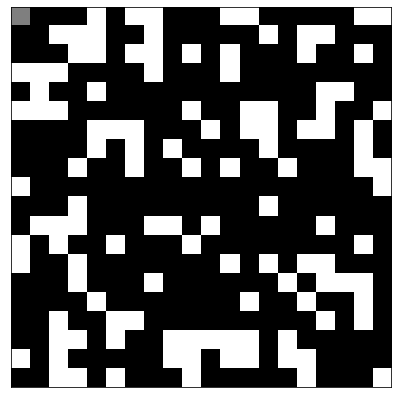

In [195]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [196]:
anim